# Build a biGRU neural network model with additional features

In this notebook, we are going to build a bidirectional Gated Recurrent Unit neural network model, which will use the clean_review feature as in the previous notebook, but this time we will also use additional features that we created in the first tutorial. The extra features that will be passed to the model are the following: polarity, subjectivity, word count, Part-Of-Speech tags ratio, uppercase words ratio and digits ratio.

In the end, the model will be evaluated on the test set to determine the generalization error.


### Model's architecture
<br>
<div>
<img src="assets/BiGRU_feat_schema.png" width="900" />
</div>

The changes that we need to do compared to the previous model are as follows, scaled additional features have to be passed to the forward method of our model, then after the GRU they will be concatenated together with max-pooled, avg-pooled and last hidden size. The concatenated tensor will be next passed to the linear layer, so we have to change its input size to hidden_size * 3 + num_features. Increasing the number of input features may cause that the model will be more susceptible to overfitting, thus some measures could be required to take to prevent that.

### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

Now, we are going to load the tarining and validation sets. We will import sets with all columns except the review column.

In [23]:
# Import the dataset. 
train_dataset = pd.read_csv('dataset/datasets_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label'])

# Change columns order
train_dataset = train_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                               'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [24]:
# Depict the first 5 rows of the training set
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,amaze good wonderful film early ninety franchi...,0.2482,0.5293,391,0.01279,0.002558,0.10740,0.1791,0.2251,0.1381,0.10740,1
1,wrong end see tell chick go crazy eat old woma...,0.1763,0.5750,145,0.00000,0.020690,0.00000,0.2137,0.1724,0.0345,0.07587,0
2,guess emperor clothe see list pbs night hopefu...,0.1145,0.5557,165,0.07880,0.000000,0.13330,0.2303,0.0909,0.2060,0.07275,0
3,earth well movie funny sweet good plot unique ...,0.3810,0.5720,55,0.01819,0.000000,0.01819,0.1637,0.1637,0.1637,0.14550,1
4,doe eye high school student kathleen beller fi...,0.2095,0.4666,688,0.01163,0.001453,0.15550,0.2006,0.1831,0.1846,0.05524,1


Before we create batches of our data, we have to normalize the numerical features so that we remove the possibility that one variable is the orders of magnitude greater than other variables, which might cause that the first one dominates other features in the dataset and this is something we don't want to happen in our model.

The polarity is within the range [-1.0, 1.0], and the subjectivity is within the range [0.0, 1.0], thus these both features don't require the scaling.

In [25]:
# Instantiate the StandardScaler
train_scaler = StandardScaler()
# Scale the features
train_dataset.iloc[:, 3:11] = train_scaler.fit_transform(train_dataset.iloc[:, 3:11])

In [27]:
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,amaze good wonderful film early ninety franchi...,0.2482,0.5293,0.925766,-0.466051,-0.029506,0.713005,-0.218791,0.986809,-0.090785,0.671761,1
1,wrong end see tell chick go crazy eat old woma...,0.1763,0.5750,-0.503381,-1.032507,3.306467,-1.496461,0.782012,-0.444239,-2.221886,-0.455286,0
2,guess emperor clothe see list pbs night hopefu...,0.1145,0.5557,-0.387190,2.457466,-0.500133,1.245828,1.262165,-2.657338,1.305950,-0.566812,0
3,earth well movie funny sweet good plot unique ...,0.3810,0.5720,-1.026239,-0.226890,-0.500133,-1.122251,-0.664234,-0.680484,0.435819,2.033656,1
4,doe eye high school student kathleen beller fi...,0.2095,0.4666,2.651199,-0.517426,-0.232807,1.702533,0.403095,-0.153684,0.865742,-1.192711,1


In [34]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/datasets_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label'])

# Change columns order
val_dataset = val_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                           'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [35]:
# Depict the first 5 rows of the validation set
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,go movie twice week sum word normally use ligh...,0.272000,0.4656,155,0.01290,0.0,0.05160,0.1807,0.1807,0.1613,0.10320,1
1,year big fan park work old boy time favorite.w...,-0.056670,0.3833,119,0.02520,0.0,0.10080,0.1681,0.1932,0.2185,0.08405,0
2,movie potential handle differently need differ...,-0.012695,0.6560,152,0.03946,0.0,0.01316,0.3157,0.1250,0.1382,0.05920,0
3,movie difficult review give away plot suffice ...,0.148400,0.5910,173,0.01156,0.0,0.08093,0.1849,0.2196,0.1272,0.10406,1
4,plot worth discussion hint corruption murder p...,0.215300,0.5790,105,0.01904,0.0,0.04760,0.1333,0.2856,0.1619,0.16190,0


In [36]:
# Instantiate the StandardScaler
val_scaler = StandardScaler()
# Scale the features
val_dataset.iloc[:, 3:11] = val_scaler.fit_transform(val_dataset.iloc[:, 3:11])

In [37]:
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,go movie twice week sum word normally use ligh...,0.272000,0.4656,-0.443496,-0.471182,-0.476247,-0.433351,-0.193510,-0.196521,0.377979,0.524956,1
1,year big fan park work old boy time favorite.w...,-0.056670,0.3833,-0.654306,0.091716,-0.476247,0.567055,-0.559484,0.142736,1.531346,-0.157714,0
2,movie potential handle differently need differ...,-0.012695,0.6560,-0.461063,0.744311,-0.476247,-1.214968,3.727638,-1.708251,-0.087803,-1.043581,0
3,movie difficult review give away plot suffice ...,0.148400,0.5910,-0.338090,-0.532506,-0.476247,0.163029,-0.071519,0.859248,-0.309605,0.555614,1
4,plot worth discussion hint corruption murder p...,0.215300,0.5790,-0.736288,-0.190191,-0.476247,-0.514684,-1.570269,2.650526,0.390078,2.617528,0


Below we will use the BatchIterator class defined in the *vocabulary* notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

We will use the min_word_count=3 and max_seq_len=0.9 as in the previous model. The batch_size entry value will be the 256, but it will turn out during the fine-tuning process (that is not presented) that for the dataset with more features the model achieves superior performance with the smaller size of the batch (batch_size=64) which helps in preventing overfitting.

In [71]:
train_iterator = BatchIterator(train_dataset, batch_size=64, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=False, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
35371/130416 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 198
Mapped words to indices
Batches created


In [72]:
val_iterator = BatchIterator(val_dataset, batch_size=64, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
19357/59089 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 195
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [50]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_feat', 'input_seq', 'target', 'x_lengths'])


As we can see above we can distinguish the following batches: *input_feat* that comprises all additional features, *input_seq* that contains cleaned reviews, *target batch* that includes target labels and *x_lengths* batch that encompasses input sequences lengths.

Notice that the *input_seq* batch has the dimensions: (batch_size, seq_len), while *input_feat* batch has the shape of (batch_size, num_features).

In [57]:
for batches in train_iterator:

    # Unpack the dictionary of batches
    input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                               batches['target'], batches['x_lengths']
        
    print('input_seq shape: ', input_seq.size())
    print('input_feat shape: ', input_feat.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([64, 44])
input_feat shape:  torch.Size([64, 10])
target shape:  torch.Size([64])
x_lengths shape:  torch.Size([64])


In [58]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                               batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('input_feat shape: ', input_feat.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([64, 179])
input_feat shape:  torch.Size([64, 10])
target shape:  torch.Size([64])
x_lengths shape:  torch.Size([64])


Now we are going to build a biGRU model that will use the *input_feat* batch as additional features vector. 

In [74]:
class BiGRU(nn.Module):
    """BiDirectional GRU neural network model.
        
    Parameters
    ----------
    hidden_size: int
        Number of features in the hidden state.
    vocab_size: int
        The size of the vocabulary.
    n_extra_feat: int
        Number of additional features.
    embedding_dim: int
        The size of each embedding vector.
    output_size: int
        Number of classes.
    n_layers: int, optional (default=1)
        Number of stacked recurrent layers.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout.
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU.

    """
    
    def __init__(self, hidden_size, vocab_size, n_extra_feat, embedding_dim, output_size, n_layers=1, dropout=0.2,
                 spatial_dropout=True, bidirectional=True):
        
        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()
        
        # Initialize attributes
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_extra_feat = n_extra_feat
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(self.dropout_p)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, 
                          dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True,
                          bidirectional=self.bidirectional)
        # Linear layer input size is equal to hidden_size * 3 + n_extra_feat, becuase
        # we will concatenate max_pooling ,avg_pooling, last hidden state and additional features
        self.linear = nn.Linear(self.hidden_size * 3 + self.n_extra_feat, self.output_size)

        
    def forward(self, input_seq, input_feat, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_feat: torch.Tensor
            Batch of additional features.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract batch_size
        self.batch_size = input_seq.size(0)
        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)
        
        if self.spatial_dropout:
            # Convert to (batch_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (batch_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)
        else:
            emb_out = self.dropout(emb_out)
        
        # Pack padded batch of sequences for RNN module
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths, batch_first=True)
                
        # GRU input/output shapes, if batch_first=True
        # Input: (batch_size, seq_len, embedding_dim)
        # Output: (batch_size, seq_len, hidden_size*num_directions)
        # Number of directions = 2 when used bidirectional, otherwise 1
        # shape of hidden: (n_layers x num_directions, batch_size, hidden_size)
        # Hidden state defaults to zero if not provided
        gru_out, hidden = self.gru(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # gru_out comprises all the hidden states in the last layer ("last" depth-wise, not time-wise)
        # For biGRu gru_out is the concatenation of a forward GRU representation and a backward GRU representation
        # hidden (h_n) comprises the hidden states after the last timestep
        
        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, batch_size, hidden_size)
        # Separate hidden state layers
        hidden = hidden.view(self.n_layers, self.n_directions, self.batch_size, self.hidden_size)
        last_hidden = hidden[-1]
        # last hidden shape (num_directions, batch_size, hidden_size)
        # Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)
        # Summed last hidden shape (batch_size, hidden_size)
        
        # Pad a packed batch
        # gru_out output shape: (batch_size, seq_len, hidden_size*num_directions)
        gru_out, lengths = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
              
        # Sum the gru_out along the num_directions
        if self.bidirectional:
            gru_out = gru_out[:,:,:self.hidden_size] + gru_out[:,:,self.hidden_size:]
        
        # Select the maximum value over each dimension of the hidden representation (max pooling)
        # Permute the input tensor to dimensions: (batch_size, hidden, seq_len)
        # Output dimensions: (batch_size, hidden_size)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.batch_size,-1)
        
        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (batch_size, hidden_size)
        avg_pool = torch.sum(gru_out, dim=1) / lengths.view(-1,1).type(torch.FloatTensor) 

        # Concatenate max_pooling, avg_pooling, hidden state and input_feat tensor
        concat_out = torch.cat([last_hidden, max_pool, avg_pool, input_feat], dim=1)

        # concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                                       batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            input_feat.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, input_feat, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                                           batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                input_feat.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, input_feat, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [61]:
# Initialize parameters
hidden_size = 8
vocab_size = len(train_iterator.word2index)
n_extra_feat = 10
embedding_dim = 200
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
epochs = 20
spatial_dropout = True

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = BiGRU(hidden_size, vocab_size, n_extra_feat, embedding_dim, output_size, n_layers, dropout,
              spatial_dropout, bidirectional=True)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=2)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/20]


Iteration: 100. Average training loss: 0.7102. Accuracy: 0.532
Iteration: 200. Average training loss: 0.6575. Accuracy: 0.573
Iteration: 300. Average training loss: 0.6263. Accuracy: 0.603
Iteration: 400. Average training loss: 0.6017. Accuracy: 0.627
Iteration: 500. Average training loss: 0.5764. Accuracy: 0.645


Iteration: 100. Average evaluation loss: 0.4944. Accuracy: 0.79

Epoch [1/20]: Train accuracy: 0.650. Train loss: 0.6286. Evaluation accuracy: 0.790. Evaluation loss: 0.4930

Start epoch [2/20]


Iteration: 100. Average training loss: 0.5233. Accuracy: 0.756
Iteration: 200. Average training loss: 0.5093. Accuracy: 0.759
Iteration: 300. Average training loss: 0.4809. Accuracy: 0.764
Iteration: 400. Average training loss: 0.4637. Accuracy: 0.770
Iteration: 500. Average training loss: 0.4377. Accuracy: 0.778


Iteration: 100. Average evaluation loss: 0.3717. Accuracy: 0.84

Epoch [2/20]: Train accuracy: 0.780. Train loss: 0.4786. Evaluation accuracy: 0.838. Evaluation loss: 0.3708

Start epoch [3/20]


Iteration: 100. Average training loss: 0.4085. Accuracy: 0.821
Iteration: 200. Average training loss: 0.4192. Accuracy: 0.817
Iteration: 300. Average training loss: 0.3953. Accuracy: 0.819
Iteration: 400. Average training loss: 0.3853. Accuracy: 0.823
Iteration: 500. Average training loss: 0.3795. Accuracy: 0.825


Iteration: 100. Average evaluation loss: 0.3363. Accuracy: 0.85

Epoch [3/20]: Train accuracy: 0.826. Train loss: 0.3951. Evaluation accuracy: 0.854. Evaluation loss: 0.3366

Start epoch [4/20]


Iteration: 100. Average training loss: 0.3627. Accuracy: 0.844
Iteration: 200. Average training loss: 0.3663. Accuracy: 0.844
Iteration: 300. Average training loss: 0.3550. Accuracy: 0.845
Iteration: 400. Average training loss: 0.3530. Accuracy: 0.845
Iteration: 500. Average training loss: 0.3371. Accuracy: 0.848


Iteration: 100. Average evaluation loss: 0.3213. Accuracy: 0.86

Epoch [4/20]: Train accuracy: 0.849. Train loss: 0.3530. Evaluation accuracy: 0.861. Evaluation loss: 0.3226

Start epoch [5/20]


Iteration: 100. Average training loss: 0.3215. Accuracy: 0.861
Iteration: 200. Average training loss: 0.3255. Accuracy: 0.860
Iteration: 300. Average training loss: 0.3244. Accuracy: 0.862
Iteration: 400. Average training loss: 0.3135. Accuracy: 0.865
Iteration: 500. Average training loss: 0.3122. Accuracy: 0.866


Iteration: 100. Average evaluation loss: 0.3124. Accuracy: 0.87

Epoch [5/20]: Train accuracy: 0.866. Train loss: 0.3184. Evaluation accuracy: 0.868. Evaluation loss: 0.3153

Start epoch [6/20]


Iteration: 100. Average training loss: 0.3023. Accuracy: 0.873
Iteration: 200. Average training loss: 0.3150. Accuracy: 0.869
Iteration: 300. Average training loss: 0.3029. Accuracy: 0.870
Iteration: 400. Average training loss: 0.2985. Accuracy: 0.871
Iteration: 500. Average training loss: 0.2980. Accuracy: 0.873


Iteration: 100. Average evaluation loss: 0.3089. Accuracy: 0.87

Epoch [6/20]: Train accuracy: 0.874. Train loss: 0.3014. Evaluation accuracy: 0.872. Evaluation loss: 0.3108

Start epoch [7/20]


Iteration: 100. Average training loss: 0.2771. Accuracy: 0.886
Iteration: 200. Average training loss: 0.2924. Accuracy: 0.882
Iteration: 300. Average training loss: 0.2767. Accuracy: 0.882
Iteration: 400. Average training loss: 0.2744. Accuracy: 0.884
Iteration: 500. Average training loss: 0.2727. Accuracy: 0.885


Iteration: 100. Average evaluation loss: 0.3075. Accuracy: 0.87

Epoch [7/20]: Train accuracy: 0.885. Train loss: 0.2781. Evaluation accuracy: 0.874. Evaluation loss: 0.3101

Start epoch [8/20]


Iteration: 100. Average training loss: 0.2596. Accuracy: 0.895
Iteration: 200. Average training loss: 0.2731. Accuracy: 0.892
Iteration: 300. Average training loss: 0.2691. Accuracy: 0.892
Iteration: 400. Average training loss: 0.2617. Accuracy: 0.892
Iteration: 500. Average training loss: 0.2642. Accuracy: 0.892


Iteration: 100. Average evaluation loss: 0.3037. Accuracy: 0.88

Epoch [8/20]: Train accuracy: 0.893. Train loss: 0.2644. Evaluation accuracy: 0.878. Evaluation loss: 0.3072

Start epoch [9/20]


Iteration: 100. Average training loss: 0.2494. Accuracy: 0.900
Iteration: 200. Average training loss: 0.2697. Accuracy: 0.895
Iteration: 300. Average training loss: 0.2523. Accuracy: 0.897
Iteration: 400. Average training loss: 0.2546. Accuracy: 0.897
Iteration: 500. Average training loss: 0.2499. Accuracy: 0.897


Iteration: 100. Average evaluation loss: 0.3034. Accuracy: 0.88

Epoch [9/20]: Train accuracy: 0.898. Train loss: 0.2545. Evaluation accuracy: 0.881. Evaluation loss: 0.3068

Start epoch [10/20]


Iteration: 100. Average training loss: 0.2429. Accuracy: 0.900
Iteration: 200. Average training loss: 0.2570. Accuracy: 0.900
Iteration: 300. Average training loss: 0.2346. Accuracy: 0.903
Iteration: 400. Average training loss: 0.2428. Accuracy: 0.902
Iteration: 500. Average training loss: 0.2351. Accuracy: 0.903


Iteration: 100. Average evaluation loss: 0.3052. Accuracy: 0.88

Epoch [10/20]: Train accuracy: 0.904. Train loss: 0.2413. Evaluation accuracy: 0.881. Evaluation loss: 0.3077

Start epoch [11/20]


Iteration: 100. Average training loss: 0.2343. Accuracy: 0.907
Iteration: 200. Average training loss: 0.2426. Accuracy: 0.907
Iteration: 300. Average training loss: 0.2267. Accuracy: 0.907
Iteration: 400. Average training loss: 0.2190. Accuracy: 0.909
Iteration: 500. Average training loss: 0.2221. Accuracy: 0.911


Iteration: 100. Average evaluation loss: 0.3087. Accuracy: 0.88

Epoch [11/20]: Train accuracy: 0.911. Train loss: 0.2274. Evaluation accuracy: 0.882. Evaluation loss: 0.3115

Training stoped by EarlyStopping


The training was stopped by EarlyStopping object because the loss didn't improve for 2 epochs. The best performance of the model was achieved at the 9th epoch with the validation accuracy of 0.881 and the loss of 0.3068. As we can see using extracted features improve the model's predictive ability on the validation set from the value of 0.878 (previous model) to 0.881.

The model's best state was saved to the checkpoint.pt file in the current directory. 

In [65]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

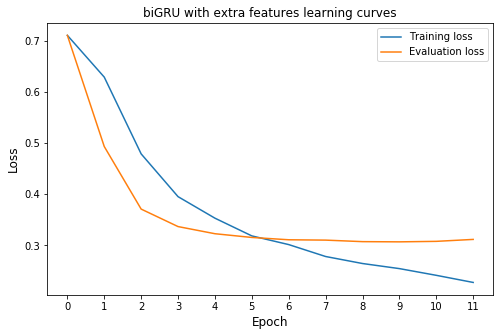

In [68]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('biGRU with extra features learning curves')
plt.xticks(ticks=range(12))
plt.legend()
plt.show()

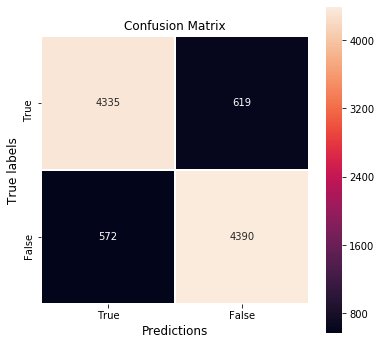

In [3]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [77]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/datasets_feat_clean/test_feat_clean.csv',
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                     'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label'])

# Change columns order
test_dataset = test_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                             'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [78]:
test_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,hear film till pop cable tv understand geena o...,-0.01698,0.4990,226,0.01770,0.004425,0.08405,0.1991,0.1903,0.0929,0.05310,1
1,know film show local tv kid remember watch see...,0.03116,0.4822,418,0.09810,0.000000,0.14830,0.1459,0.1698,0.2057,0.06940,0
2,admire kiss mouth frankness  pubic hair cut m...,-0.05817,0.5215,298,0.01342,0.000000,0.03693,0.1544,0.2214,0.1913,0.12760,0
3,see cure kid love year late get hold copy acci...,0.08920,0.5264,757,0.03568,0.000000,0.04755,0.1770,0.1783,0.1625,0.07135,1
4,movie true fact see documentary day early movi...,0.12930,0.4688,186,0.01613,0.000000,0.02689,0.1774,0.1720,0.0914,0.08060,0


In [79]:
# Instantiate the StandardScaler
test_scaler = StandardScaler()
# Scale the features
test_dataset.iloc[:, 3:11] = test_scaler.fit_transform(test_dataset.iloc[:, 3:11])

In [80]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
13480/39104 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 187
Mapped words to indices
Batches created


In [81]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

In [82]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.882. Test error: 0.309


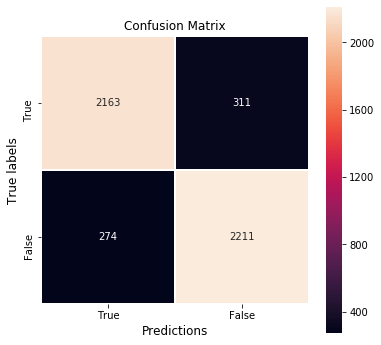

In [5]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

Thanks to using additional features our model achieved the generalization error of 0.882, which is 0.02 better than in the model without using extracted features. Even a superior result is possible, but the precise process of hyperparameters fine-tuning will be required.